In [199]:
import pandas as pd
df = pd.read_csv("/tmp/temp.csv")

In [200]:
df['buy_amount'] = df['buy_amount'].divide(df['mid'])
df['sell_amount'] = df['sell_amount'].divide(df['mid'])

In [201]:
diff = df[['mid', 'balance']]
diff = diff.pct_change().dropna()
dd = diff.cumsum(axis=0).iloc[:-10]

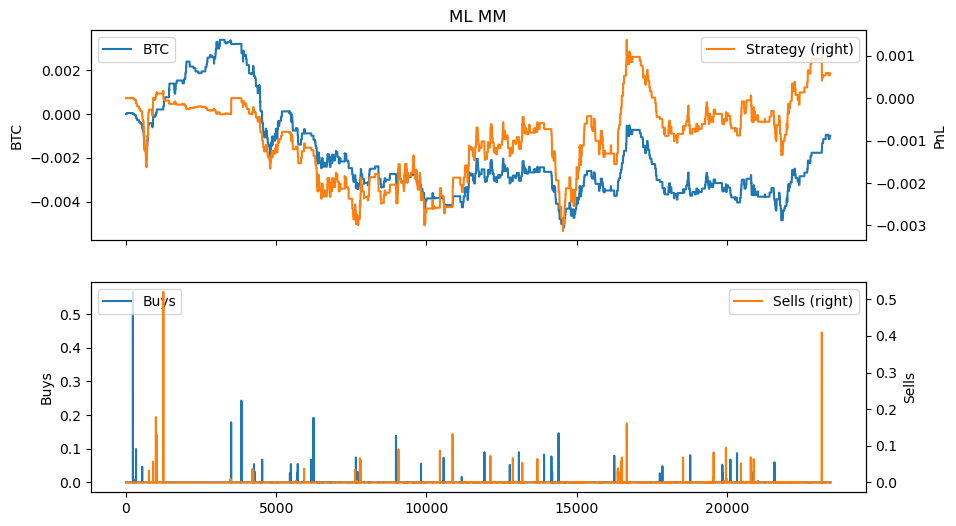

In [202]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 20))
dd['mid'].plot(label='BTC', figsize=(10, 6), ax=ax1)
dd['balance'].plot(secondary_y=True, label='Strategy', ax=ax1)

ax1.set_ylabel('BTC')
ax1.right_ax.set_ylabel('PnL')
plt.title('ML MM')
ax1.legend(loc='upper left')
ax1.right_ax.legend(loc='upper right')

df['buy_amount'].diff().dropna().plot(label="Buys", ax=ax2)
df['sell_amount'].diff().dropna().plot(label='Sells', secondary_y=True, ax=ax2)
ax2.set_ylabel('Buys')
ax2.right_ax.set_ylabel('Sells')
ax2.legend(loc='upper left')
ax2.right_ax.legend(loc='upper right')
plt.show()

<Axes: >

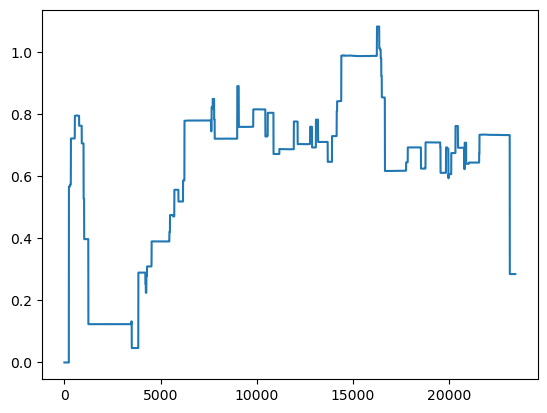

In [203]:
df['leverage'].plot()